# Table of Contents* [1. Import Libraries](#import-library)
*  [2. Data Pre-processing](#data-preprocessing)
* [3. Build Model](#build-model)
* [4. Predict for test dataset](#predict-1)
* [5. Predict for last cycle of each unit](#predict-2)ction_3_2_1)

## 1. Import libraries <a id=”import-library″></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import keras.models
import keras.layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## 2. Data pre-processing <a id=”data-preprocessing″></a>

### Read dataset

In [2]:
data_train = pd.read_csv("./dataset/train_FD001.txt",sep=" ",header=None)
data_test = pd.read_csv("./dataset//test_FD001.txt",sep=" ",header=None)
data_RUL = pd.read_csv("./dataset/RUL_FD001.txt",sep=" ",header=None)

In [3]:
data_train.drop(columns=[26,27],inplace=True)
data_test.drop(columns=[26,27],inplace=True)
data_RUL.drop(columns=[1],inplace=True)

In [4]:
columns_train = ['unit_ID','cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
data_train.columns = columns_train

In [8]:
# Input: data_length: độ dài chuỗi target cần tạo
#        rul_threshhold: ngưỡng rul phân chia giai đoạn khỏe mạnh và suy thoái
# Output: mảng targets
def process_targets(data_length, rul_threshold):
    rul_threshold_duration = data_length - rul_threshold
    if rul_threshold_duration <= 0:
        return np.arange(data_length-1, -1, -1)
    else:
        return np.append(rul_threshold*np.ones(shape = (rul_threshold_duration,)), np.arange(rul_threshold-1, -1, -1))

In [7]:
# Input: input_data: data của các features 
#        target_data: data của label
#        window_length: kích thước cửa sổ
# Output: output_data: chuỗi dữ liệu đầu vào của mô hình
#         output_target: chuỗi dữ liệu đầu ra mô hình 
def process_input_data_with_targets(input_data, target_data = None, window_length = 1):
    num_batches = len(input_data)-window_length + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[batch:(batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[batch:(batch+window_length),:]
            output_targets[batch] = target_data[batch + (window_length-1)]
        return output_data, output_targets

In [9]:
# Input: test_data_for_an_engine: feature data của một unit
#        window_length: độ dài của sổ
# Output: batched_test_data_for_an_engine: chuỗi dữ liệu test của mô hình
#         nếu test_data ít -> lấy tất cả
#         nếu test_data đủ lớn -> lấy k điểm cuối của test_data(k phụ thuộc vào window_length và number_test_window), 
def process_test_data(test_data_for_an_engine, window_length, num_test_windows = 1):
  
    max_num_test_batches = len(test_data_for_an_engine)-window_length+ 1
    if max_num_test_batches < num_test_windows:
        required_len = max_num_test_batches-1+ window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = num_test_windows-1+window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length= window_length)
        return batched_test_data_for_an_engine, num_test_windows

In [13]:
test_data = pd.read_csv("./dataset/test_FD001.txt", sep = "\s+", header = None,names=columns_train )
true_rul = pd.read_csv("./dataset/RUL_FD001.txt", sep = '\s+', header = None)

window_length = 30
num_test_windows = 5   
rul_threshold = 125           
processed_train_data = []
processed_train_targets = []
  
processed_test_data = []
num_test_windows_list = []

columns_to_be_dropped =['unit_ID','setting_1','setting_2','setting_3', 'T2', 'P2','P15','P30', 'epr',
                 'farB', 'Nf_dmd', 'PCNfR_dmd']

train_data_first_column = data_train ["unit_ID"]
test_data_first_column = test_data["unit_ID"]

### Data scaling

In [14]:
scaler = StandardScaler()
train_data = scaler.fit_transform(data_train.drop(columns = columns_to_be_dropped))
test_data = scaler.transform(test_data.drop(columns = columns_to_be_dropped))

train_data = pd.DataFrame(data = np.c_[train_data_first_column, train_data])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test_data])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

### Gen sequence for training dataset

In [17]:
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Determine whether it is possible to extract training data with the specified window length.
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], rul_threshold = rul_threshold)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length= window_length)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

### Gen sequence for test dataset

In [22]:
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Determine whether it is possible to extract test data with the specified window length.
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length=window_length,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)
true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]

In [23]:
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (17731, 30, 14)
Processed training ruls shape:  (17731,)
Processed test data shape:  (497, 30, 14)
True RUL shape:  (100,)


In [24]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (14184, 30, 14)
Processed validation data shape:  (3547, 30, 14)
Processed train targets shape:  (14184,)
Processed validation targets shape:  (3547,)


## 3. Build model <a id=”build-model″></a>

In [26]:
def create_compiled_model():
    model = Sequential([
        layers.LSTM(128, input_shape = (window_length, 14), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

In [27]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10

111/111 - 14s - loss: 3069.5181 - val_loss: 319.2651 - lr: 0.0010 - 14s/epoch - 125ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 8s - loss: 213.5770 - val_loss: 175.2153 - lr: 0.0010 - 8s/epoch - 71ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 8s - loss: 151.5990 - val_loss: 140.1255 - lr: 0.0010 - 8s/epoch - 70ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 8s - loss: 125.3000 - val_loss: 111.4861 - lr: 0.0010 - 8s/epoch - 68ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 7s - loss: 109.9115 - val_loss: 111.0373 - lr: 0.0010 - 7s/epoch - 67ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 8s - loss: 85.0628 - val_loss: 88.2455 - lr: 1.0000e-04 - 8s/epoch - 71ms/step

Epoch 7: LearningR

In [28]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model = create_compiled_model()
history = model.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),
                    callbacks = callback,
                    batch_size = 128, verbose = 2)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
111/111 - 13s - loss: 3236.9587 - val_loss: 898.4872 - lr: 0.0010 - 13s/epoch - 121ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
111/111 - 8s - loss: 790.2641 - val_loss: 639.4262 - lr: 0.0010 - 8s/epoch - 72ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
111/111 - 8s - loss: 435.6321 - val_loss: 330.5824 - lr: 0.0010 - 8s/epoch - 70ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
111/111 - 8s - loss: 315.4914 - val_loss: 258.1222 - lr: 0.0010 - 8s/epoch - 69ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
111/111 - 8s - loss: 267.5785 - val_loss: 245.6664 - lr: 0.0010 - 8s/epoch - 75ms/step

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
111/111 - 8s - loss: 217.7299 - val_loss: 209.1983 - lr: 1.0000e-04 - 8s/epoch - 71ms/step

Epoch 7: LearningR

Measure the difference between predicted and actual values.
RMSE = sqrt(1/n * Σ(actual_i - predicted_i)^2)

## 4. Predict for test dataset <a id=”predict-1″></a>

In [29]:
rul_pred = model.predict(processed_test_data).reshape(-1)
preds_for_each_engine = np.split(rul_pred, np.cumsum(num_test_windows_list)[:-1])
mean_pred_for_each_engine = [np.average(ruls_for_each_engine, weights = np.repeat(1/num_windows, num_windows)) 
                             for ruls_for_each_engine, num_windows in zip(preds_for_each_engine, num_test_windows_list)]
RMSE = np.sqrt(mean_squared_error(true_rul, mean_pred_for_each_engine))
print("RMSE: ", RMSE)

16/16 [==============================] - 1s 11ms/step
RMSE:  14.73500640795721


In [31]:
# Dự báo RUL tại chu kỳ mới nhất của mỗi máy trong tập test
tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")

indices_of_last_examples = np.cumsum(num_test_windows_list) - 1
preds_for_last_example = np.concatenate(preds_for_each_engine)[indices_of_last_examples]

RMSE_new = np.sqrt(mean_squared_error(true_rul, preds_for_last_example))
print("RMSE (Taking only last examples): ", RMSE_new)

RMSE (Taking only last examples):  15.76292754752603


C:\Users\Admin\AppData\Local\Temp\ipykernel_6240\3377970016.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, "FD001_LSTM_piecewise_RMSE_"+ str(np.round(RMSE, 4)) + ".h5")


## 5. Predict for last cycle of each unit <a id=”predict-2″></a>

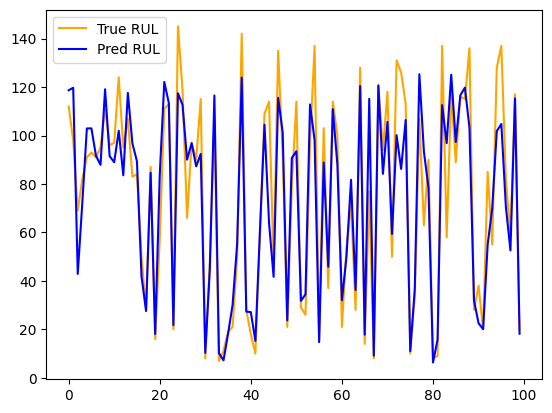

In [32]:
plt.plot(true_rul, label = "True RUL", color = "orange")
plt.plot(preds_for_last_example, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()